# Analyse des clients du site d'e-commerce Olist

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
from function_utils import haversine_vectorize

In [2]:
sns.set_palette("Pastel2")

## 1) Création d'une segmentation RFM

On débute l'analyse de notre base de clients par la création d'une segmentation RFM (Recency, Frequency, MonetaryValue). Ce type de segmentation est utilisé en marketing pour pouvoir découper les clients en segments actionnables et ainsi adapter les stratégies en fonction du type de client. La segmentation RFM se base sur des habitudes de consommations comme la date du dernier achat (Recency), la fréquence d'achat (Frequency) et la valeur moyenne/la somme moyenne dépensée lors d'une commande (MonetaryValue).  

### Information clients

On va commencer par extraire les informations clients pour pouvoir déterminer les premières variables de notre segmentation. 

In [3]:
df_customers = pd.read_csv("datasets/olist_customers_dataset.csv")
df_geo = pd.read_csv("datasets/olist_geolocation_dataset.csv")

In [4]:
# Add geolocation information
df_customers = pd.merge(df_geo, df_customers,
                        right_on=["customer_zip_code_prefix",
                                  "customer_city", "customer_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city", "geolocation_state"],
                        how="right")
df_customers.drop(["geolocation_zip_code_prefix", "geolocation_city",
                   "geolocation_state"], axis=1, inplace=True)
df_customers = df_customers[["customer_id", "customer_unique_id",
                             "customer_city", "geolocation_lat",
                             "geolocation_lng"]]
df_customers.columns = ["customer_id", "customer_unique_id",
                        "customer_city", "customer_latitude",
                        "customer_longitude"]
df_customers.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.497396,-47.399241
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.510459,-47.399553
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.480940,-47.394161
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.515413,-47.398194


In [5]:
df_customers.drop_duplicates(subset="customer_unique_id", 
                             inplace=True)

In [6]:
print("Nombre d'id unique:", df_customers["customer_unique_id"].nunique())

Nombre d'id unique: 96096


In [7]:
print("Nombre d'id clients:", df_customers["customer_id"].nunique())

Nombre d'id clients: 96096


### Information sur les commandes

On va ensuite s'intéresser aux informations des commandes pour calculer

In [8]:
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv")

In [9]:
# Association between customers and orders
# In order to calculate Frequency and Recency
df = pd.merge(df_customers,
              df_orders,
              left_on="customer_id",
              right_on="customer_id",
              how="right")
df.drop_duplicates(subset="customer_id",
                   inplace=True)

In [10]:
df_orders_payments = pd.read_csv("datasets/olist_order_payments_dataset.csv")

In [11]:
# Association between customers, orders and orders payments
# In order to calculate MonetaryValue
df = pd.merge(df, df_orders_payments, left_on="order_id",
              right_on="order_id", how="right")

In [12]:
# Transformation timestamps into datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

In [13]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)

In [14]:
# Creation of RFM segmentation
rfm_custom = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]
data = rfm_custom.copy().reset_index()

In [15]:
# Calculation of scores with the help of quartiles
# Except for the frequency
data['r_quartile'] = pd.qcut(data['Recency'], 4, ['1', '2', '3', '4'])
data['f_bins'] = pd.cut(data['Frequency'], 2, labels=['2', '1'])
data['m_quartile'] = pd.qcut(data['MonetaryValue'], 4, ['4', '3', '2', '1'])

In [16]:
# Creation of RFM Score with the concatenation of
# R, F & M quartile/bins
data['RFM_Score'] = data["r_quartile"].astype(str) \
                    + data["f_bins"].astype(str) \
                    + data["m_quartile"].astype(str)
data.sort_values("RFM_Score", ascending=True)

,customer_unique_id,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
42174,7020078859b9015b76e7469322c2c415,77,1,190.40,1,2,1,121
46944,7cc8c55781241cb0699be8b935e8e5a2,141,1,357.90,1,2,1,121
88914,eca9d15ebd1b37acb67bd1c3e3ca5b2c,78,1,405.03,1,2,1,121
9164,18360e41b00709cc7b2c6f391eff829e,121,1,1839.05,1,2,1,121
46965,7cd747a15b6eb374e2706259c27e96a8,158,1,309.57,1,2,1,121
...,...,...,...,...,...,...,...,...
53217,8df1329b564044430fe684b6632f0c8a,595,1,58.46,4,2,4,424
53216,8df10be00a35becbb4993496f949d948,589,1,45.64,4,2,4,424
91541,f3cb4bf78563e8f29fb8df63f3ae2748,473,1,51.14,4,2,4,424
53276,8e1c8e08724097b43730e4344f3200db,472,1,45.61,4,2,4,424


On remarque que la fréquence d'achat est le plus souvent de 1. Le choix a donc été fait de faire une binarisation de cette donnée en 1 (un achat) et 2 (plus d'un achat). Ce problème sur la fréquence d'achat va se répercuter sur la récence. Enfin, pour le montant dépensé, les calculs ont pu être fait classiquement. La séparation a été réalisée sur la base des quartiles. 

Une fois la discrétisation des variables R, F et M réalisée, on crée un score qui correspond à la concaténation de ces trois indices. Ainsi, on obtient une segmentation RFM composée de 32 segments (4 x 2 x 4).

### Analyse de la segmentation RFM

In [17]:
# Describe statistics
data.describe()

,Recency,Frequency,MonetaryValue
count,96095.000000,96095.000000,96095.000000
mean,290.107727,1.044342,158.636702
std,153.607874,0.380658,220.154652
min,1.000000,1.000000,0.000000
25%,166.000000,1.000000,60.235000
50%,271.000000,1.000000,103.420000
75%,400.000000,1.000000,175.080000
max,773.000000,29.000000,13664.080000


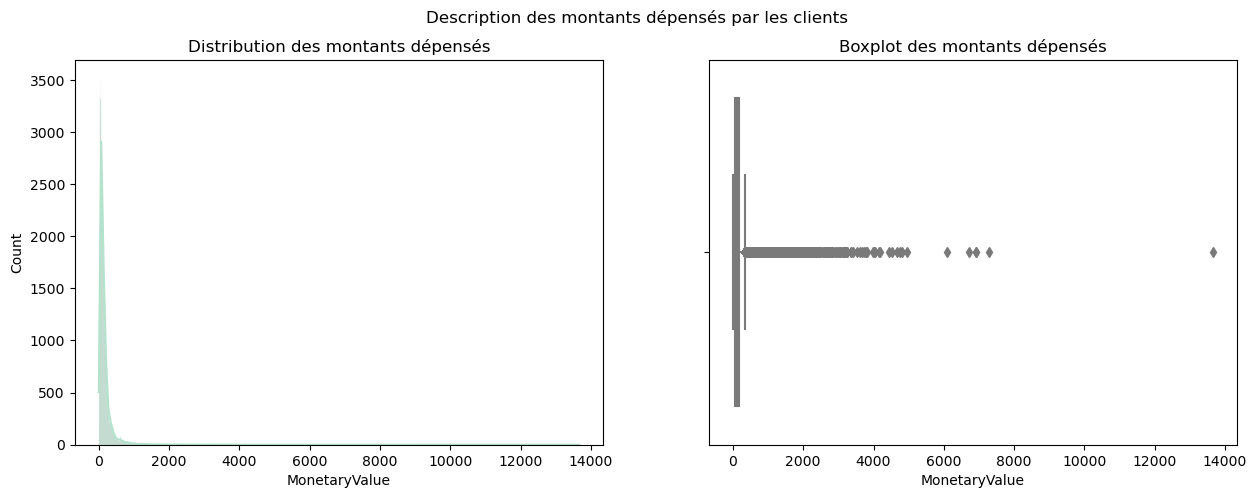

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0], x="MonetaryValue", data=data, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=data)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

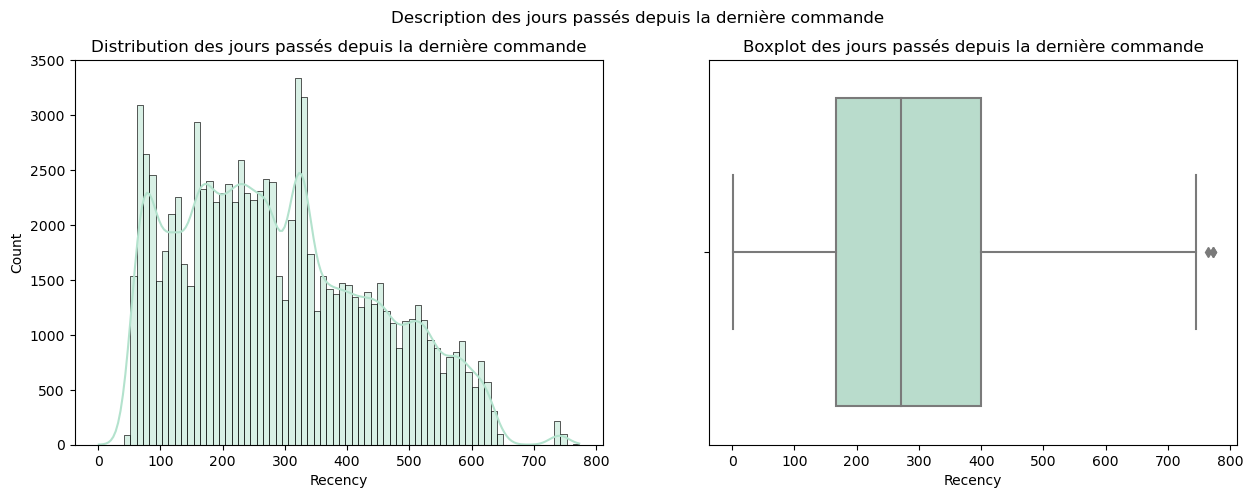

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0], x="Recency", data=data, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Recency", data=data)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()

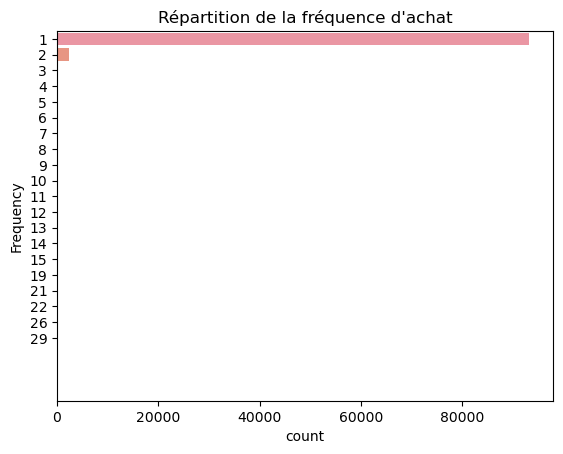

In [20]:
sns.countplot(y="Frequency", data=data)
plt.ylim(23)
plt.title("Répartition de la fréquence d'achat")

plt.show()

## Conclusion

La fréquence et la récence ne semblent pas être très discriminants. En effet, la plupart des clients réalise un seul achat. De même, il est difficile de savoir s'ils reviennent régulièrement acheter donc la récence est très variable. Les sommes dépensées atteignent un maximum de 14.000 Réaux. 

En inspectant le fonctionnement du site, il s'avère que l'on peut commander sans avoir besoin de créer un compte. On ne peut donc pas savoir si une personne commande plusieurs fois et obtenir les informations nécessaires. Il pourrait être intéressant d'instaurer un système de compte pour obtenir des informations plus stables sur la récence et la fréquence. A défaut, un système de cookies pouvant "tracker" (tout en respectant les législations en vigueur) peut être une solution permettant de remédier à ce problème. 

In [21]:
del df_orders_payments
del rfm_custom

In [22]:
gc.collect()

169331

In [23]:
data.set_index("customer_unique_id", inplace=True)

In [24]:
data.to_csv("datasets/data_segmentation_rfm.csv")

## 2) Ajout de variables supplémentaires

On va créer de nouvelles variables que l'on va ajouter pour pouvoir obtenir une segmentation plus fine. Parmi ces variables, on va ajouter le nombre de jours entre la commande (order_approved_at) et la réception de cette dernière, la distance entre le client et le vendeur, l'avis du client et la catégorie de produits commandée. 

In [25]:
data.reset_index(inplace=True)

### Calcul des distances entre vendeurs et acheteurs

In [26]:
df_sellers = pd.read_csv("datasets/olist_sellers_dataset.csv")

In [27]:
df_sellers = pd.merge(df_geo, df_sellers,
                        right_on=["seller_zip_code_prefix",
                                  "seller_city",
                                  "seller_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city",
                                 "geolocation_state"],
                        how="right")
df_sellers.drop(["geolocation_zip_code_prefix",
                 "geolocation_city",
                 "geolocation_state"], axis=1, inplace=True)
df_sellers = df_sellers[['seller_id',
                         "geolocation_lat",
                         "geolocation_lng"]]
df_sellers.columns = ["seller_id",
                      "seller_latitude",
                      "seller_longitude"]

In [28]:
df_sellers.drop_duplicates(subset="seller_id", inplace=True)

In [29]:
df_items = pd.read_csv("datasets/olist_order_items_dataset.csv")

In [30]:
df_items = pd.merge(df_orders, df_items, on="order_id", how="left")

In [31]:
df_items = pd.merge(df_items, df_customers, on="customer_id", how="left")

In [32]:
df_items = pd.merge(df_sellers, df_items, on="seller_id", how="left")

In [33]:
df_items.dropna(subset=["customer_city"], inplace=True)

In [34]:
df_items["distance_customer_seller"] = haversine_vectorize(
    df_items["customer_longitude"],
    df_items["customer_latitude"],
    df_items["seller_longitude"],
    df_items["seller_latitude"])

In [35]:
df_items = df_items[["customer_unique_id",
                     "product_id",
                     "distance_customer_seller"]]
data = pd.merge(data, df_items,
                on="customer_unique_id",
                how="left")

### Informations sur le type de produits commandés

In [36]:
df_products = pd.read_csv("datasets/olist_products_dataset.csv")
df_translation = pd.read_csv("datasets/product_category_name_translation.csv")
df_products = pd.merge(df_products,
                       df_translation,
                       on="product_category_name")
df_products = df_products[["product_id",
                           "product_category_name_english"]]
df_products.rename(columns={"product_category_name_english" : "product_category_name"}, 
                   inplace=True)

In [37]:
data = pd.merge(data, df_products, on="product_id", how="left")
data.drop("product_id", axis=1, inplace=True)

### Informations sur les avis clients

In [38]:
df_reviews = pd.read_csv("datasets/olist_order_reviews_dataset.csv")

In [39]:
df_reviews.drop(["review_id", "review_creation_date",
                 "review_answer_timestamp"],
                axis=1,
                inplace=True)

In [40]:
df_reviews["review_score"] = df_reviews["review_score"].astype("int32")

In [41]:
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv")

In [42]:
df_orders.drop(["order_purchase_timestamp",
                "order_delivered_carrier_date"], axis=1, inplace=True)
cols_time = ["order_approved_at",
             "order_delivered_customer_date",
             "order_estimated_delivery_date"]

for cols in cols_time:
    df_orders[cols] = pd.to_datetime(df_orders[cols],
                                     format="%Y-%m-%d",
                                     errors="ignore")

In [43]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_approved_at              99281 non-null  datetime64[ns]
 4   order_delivered_customer_date  96476 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 4.6+ MB


### Calcul entre du nombre de jours entre la commande et la réception réel et estimé

In [44]:
df_orders["nb_days_before_delivered"] = df_orders["order_delivered_customer_date"] \
                                        - df_orders["order_approved_at"]
df_orders["nb_days_before_delivered_estimation"] = df_orders["order_estimated_delivery_date"] \
                                                   - df_orders["order_approved_at"]

cols_var = ["nb_days_before_delivered",
            "nb_days_before_delivered_estimation"]

for cols in cols_var:
    df_orders[cols] = df_orders[cols].dt.days

df_orders.drop(["order_approved_at",
                "order_delivered_customer_date",
                "order_estimated_delivery_date"], axis=1, inplace=True)

### Assemblage des différentes variables pour obtenir un dataset unique

In [45]:
df_customers_orders = pd.merge(df_customers,
                               df_orders,
                               on="customer_id",
                               how="left")

In [46]:
df_customers_orders = pd.merge(df_customers_orders,
                               df_reviews,
                               on="order_id",
                               how="left")

In [47]:
df_customers_orders.drop(["order_id"], axis=1, inplace=True)

In [48]:
df_customers_orders = df_customers_orders.groupby("customer_unique_id").mean()
df_customers_orders.reset_index(inplace=True)

In [49]:
data = pd.merge(data, df_customers_orders, on="customer_unique_id", how="left")

In [50]:
data = pd.merge(df_customers, data, on="customer_unique_id", how="right")

In [51]:
data.drop_duplicates(subset="customer_unique_id", inplace=True)

In [52]:
data.drop(["customer_id",
           "customer_longitude_x",
           "customer_latitude_x",
           "customer_longitude_y",
           "customer_latitude_y"], axis=1, inplace=True)
data.set_index("customer_unique_id",
               inplace=True)

In [53]:
data = data.loc[data["nb_days_before_delivered"] > 0]
data = data.loc[data["nb_days_before_delivered_estimation"] > 0]
data = data.loc[data["distance_customer_seller"] > 0]

In [54]:
data["review_score"] = data["review_score"].astype("int32")

## 3) Analyse des données clients

In [55]:
# Descriptive statistics
data.describe()

,Recency,Frequency,MonetaryValue,distance_customer_seller,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
count,90205.000000,90205.000000,90205.000000,90205.000000,90205.000000,90205.000000,90205.000000
mean,288.489618,1.044100,156.600685,603.943571,11.688654,22.894851,4.138762
std,152.563602,0.370922,216.720029,599.119124,9.570794,8.757824,1.297214
min,50.000000,1.000000,1.737500,0.174640,1.000000,1.000000,1.000000
25%,165.000000,1.000000,60.000000,189.109677,6.000000,18.000000,4.000000
50%,269.000000,1.000000,102.740000,436.099314,9.000000,22.000000,5.000000
75%,397.000000,1.000000,173.880000,802.679213,15.000000,28.000000,5.000000
max,745.000000,26.000000,13664.080000,8731.462170,208.000000,153.000000,5.000000


### Analyses univariées des variables utilisées pour la segmentation

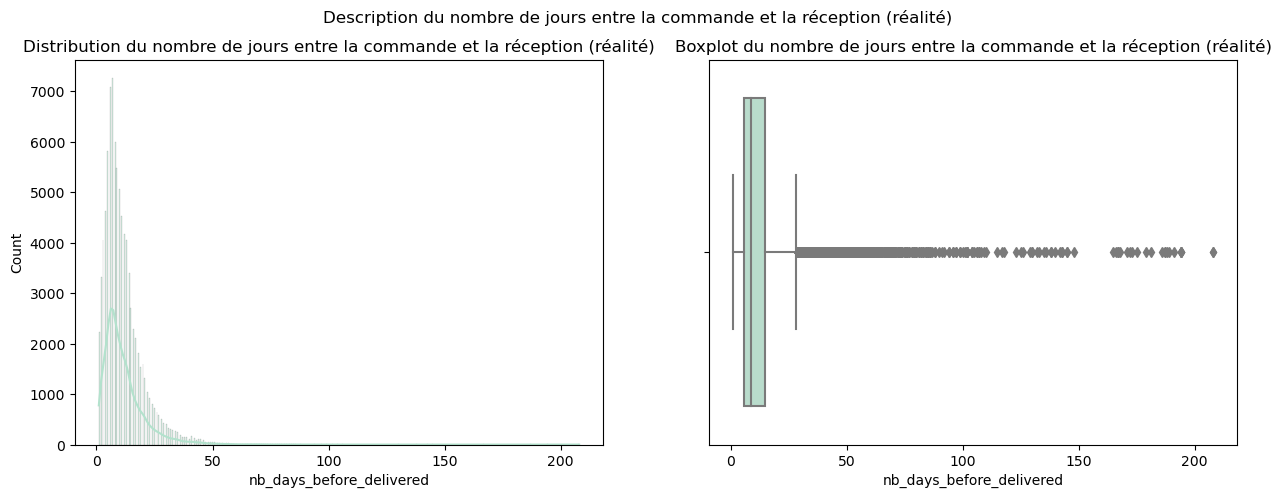

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Description du nombre de jours entre la commande et la réception (réalité)')

sns.histplot(ax=axes[0], x="nb_days_before_delivered", data=data, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (réalité)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered", data=data)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (réalité)")

plt.show()

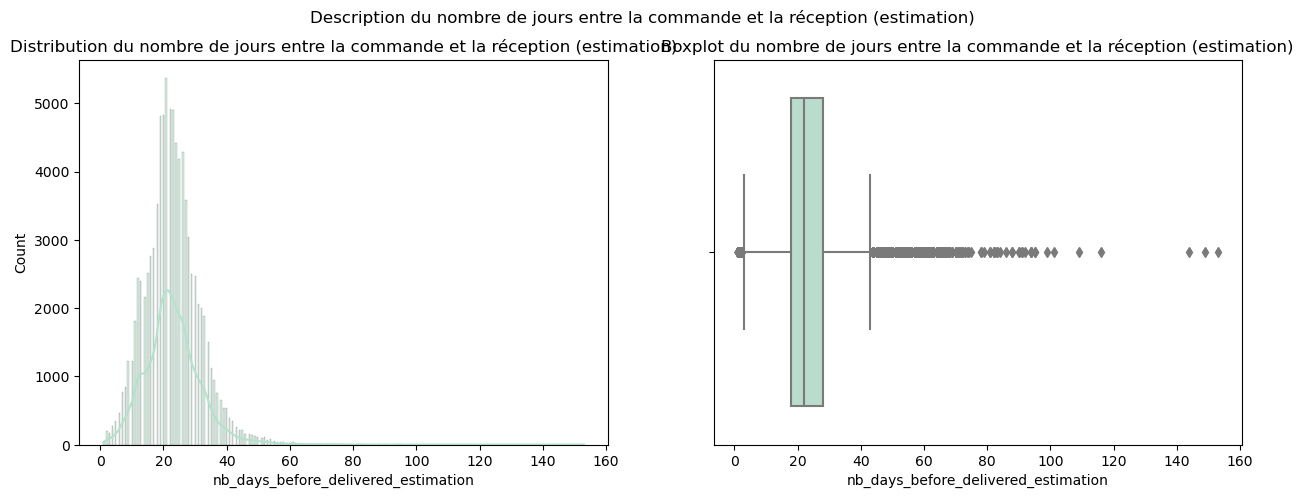

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du nombre de jours entre la commande et la réception (estimation)')

sns.histplot(ax=axes[0], x="nb_days_before_delivered_estimation", data=data, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (estimation)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered_estimation", data=data)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (estimation)")

plt.show()

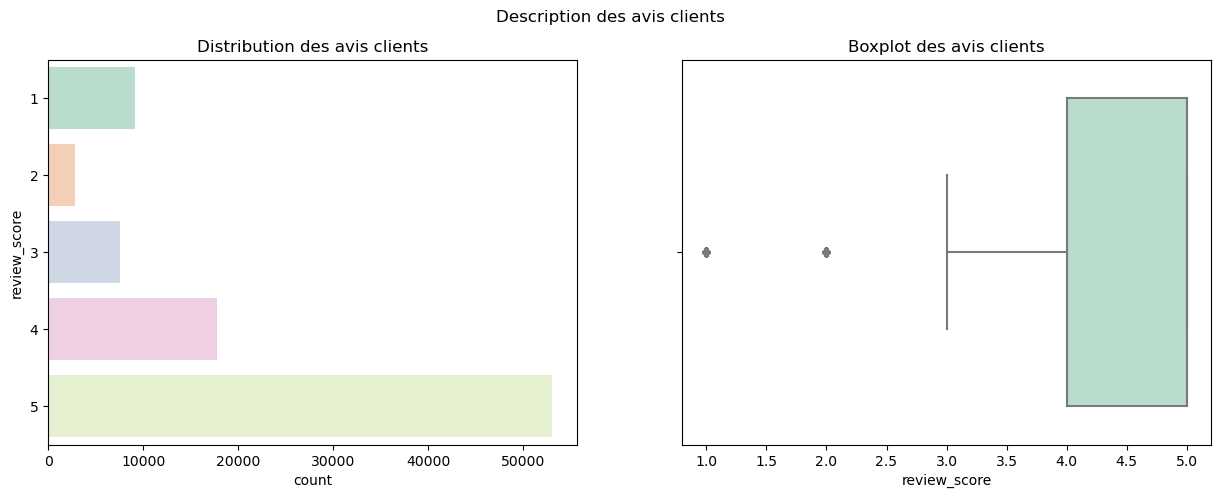

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False)
fig.suptitle('Description des avis clients')

sns.countplot(ax=axes[0], y="review_score", data=data)
axes[0].set_title("Distribution des avis clients")

sns.boxplot(ax=axes[1], x="review_score", data=data)
axes[1].set_title("Boxplot des avis clients")

plt.show()

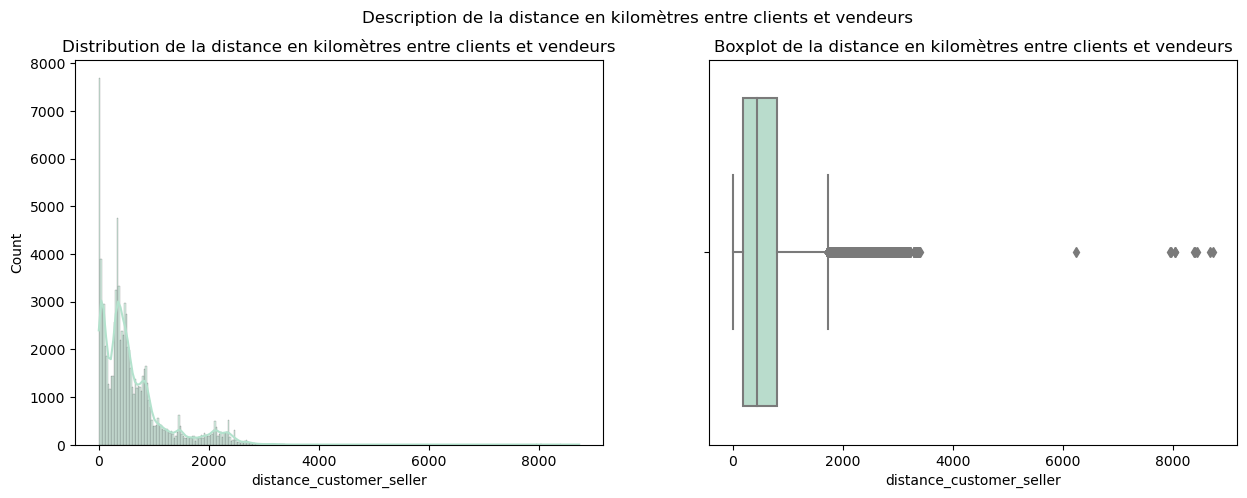

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la distance en kilomètres entre clients et vendeurs')

sns.histplot(ax=axes[0], x="distance_customer_seller", data=data, kde=True)
axes[0].set_title("Distribution de la distance en kilomètres entre clients et vendeurs")

sns.boxplot(ax=axes[1], x="distance_customer_seller", data=data)
axes[1].set_title("Boxplot de la distance en kilomètres entre clients et vendeurs")

plt.show()

In [60]:
data.drop("nb_days_before_delivered_estimation", axis=1, inplace=True)
data.to_csv("datasets/data_clustering_complete.csv")

**Ressources :**

- Intégration de la plateforme Olist sur le site de Carrefour Brésil: https://www.carrefour.com.br/parceiro/olist